# 1. Imports


In [1]:
import concurrent.futures
import os

from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# from genieclust import Genie
from scipy.io import loadmat
from hdbscan import HDBSCAN
from sklearn import metrics
import pandas as pd
import numpy as np
import h5py


# 2. Functions

In [2]:
def load_mat_file_v73(file_path: str) -> pd.DataFrame:
    with h5py.File(file_path, "r") as file:
        print(list(file.keys()))

        X = file["X"][()]
        y = file["y"][()]

        X = np.transpose(X)
        y = np.transpose(y).flatten()

        df = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(X.shape[1])])
        df["label"] = y

    return df


def load_mat_file(file_path: str) -> pd.DataFrame:
    try:
        data = loadmat(file_path)
    except NotImplementedError:
        data = load_mat_file_v73(file_path)

    X = data["X"]
    y = data["y"].flatten()

    df = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(X.shape[1])])
    df["label"] = y

    return df


def run_with_timeout(func, args, timeout):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future = executor.submit(func, *args)
        try:
            return future.result(timeout=timeout)
        except concurrent.futures.TimeoutError:
            return


In [3]:
def plot_one_dataset(results):
    metrics = ["auc_score", "accuracy", "precision", "recall"]
    labels = list(results.keys())
    data = {metric: [results[label][metric] for label in labels] for metric in metrics}

    num_metrics = len(metrics)
    x = np.arange(len(labels))
    width = 0.2

    fig, axes = plt.subplots(nrows=1, ncols=num_metrics, figsize=(15, 5), sharey=True)

    for i, metric in enumerate(metrics):
        axes[i].bar(x, data[metric], width, label=metric)
        axes[i].set_title(metric)
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(labels, rotation=45)
        axes[i].set_xlabel("Algorithms")
        axes[i].set_ylim(0, 1)

    fig.tight_layout(pad=3.0)
    fig.suptitle("Comparison of Anomaly Detection Algorithms", fontsize=16, y=1.05)
    plt.show()


In [4]:
def apply_dbscan(X):
    model = DBSCAN(eps=0.3, min_samples=10)
    return model.fit_predict(X)


def apply_hdbscan(X):
    model = HDBSCAN(min_cluster_size=15)
    return model.fit_predict(X)


def apply_one_class_svm(X):
    model = OneClassSVM(nu=0.05)
    return model.fit(X).predict(X)


def apply_isolation_forest(X):
    model = IsolationForest()
    return model.fit(X).predict(X)


def apply_lof(X):
    model = LocalOutlierFactor(n_neighbors=20)
    return model.fit_predict(X)


def apply_kmeans(X):
    # Ustawienie liczby klastrów
    n_clusters = 8  # Można dostosować w zależności od rozkładu danych
    model = KMeans(n_clusters=n_clusters)
    # Fit model
    clusters = model.fit_predict(X)
    # Obliczenie odległości od najbliższego centrum klastra dla każdego punktu
    distances = np.linalg.norm(X - model.cluster_centers_[clusters], axis=1)
    # Ustalenie progu odległości dla detekcji anomalii (np. 95 percentyl)
    threshold = np.percentile(distances, 95)
    # Zwracanie -1 dla anomalii i 1 dla normalnych obserwacji
    return np.where(distances > threshold, -1, 1)


# def apply_genie(X):
#     model = Genie(n_clusters=2)
#     return model.fit_predict(X)


In [5]:
def evaluate_model(predictions, true_labels) -> dict[str, float]:
    predictions = (predictions == -1).astype(int)

    auc_score = metrics.roc_auc_score(true_labels, predictions)
    accuracy = metrics.accuracy_score(true_labels, predictions)
    precision = metrics.precision_score(true_labels, predictions)
    recall = metrics.recall_score(true_labels, predictions)

    results = {
        "auc_score": auc_score,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall
    }

    return results


def test_dataset(dataset, functions) -> dict[str, tuple]:
    dataset_results = {}

    x = dataset.drop("label", axis=1)
    y = dataset["label"]

    for function_name in functions:
        the_function = functions[function_name]
        predictions = the_function(x)
        results = evaluate_model(predictions, y)

        dataset_results[function_name] = results

    return dataset_results


# 3. Reading and testing data

In [6]:
folder_path = "data"

mat_files = []

for file in os.listdir(folder_path):
    if file.endswith(".mat"):
        mat_files.append(f"{folder_path}/{file}")

print("Mat files:", len(mat_files))


Mat files: 27


In [7]:
functions = {
    "DBSCAN": apply_dbscan,
    "HDBSCAN": apply_hdbscan,
    "One-class SVM": apply_one_class_svm,
    "Isolation Forests": apply_isolation_forest,
    "Local Outlier Factor": apply_lof,
    "KMeans": apply_kmeans
    # "Genie": apply_genie
}


In [8]:
limit_time = 20
results = {}

black_list = (
    "cover",  # too long
    "ecoli",  # empty file
    "http",  # incorrect file type
    "smtp",  # incorrect file type
)


for file_path in mat_files:
    name_tmp = file_path.split("/")[1][:-4]

    if name_tmp in black_list:
        print("[X]", name_tmp)
        continue

    dataset_tmp = load_mat_file(file_path)

    results_tmp = run_with_timeout(test_dataset, [dataset_tmp, functions], limit_time)
    if results_tmp is None:
        print("[-]", name_tmp)
        continue

    print("[+]", name_tmp)
    results[name_tmp] = results_tmp


C:\Users\Studia\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[+] annthyroid
[+] arrhythmia
[+] breastw
[+] cardio
[X] cover
[X] ecoli
[+] glass
[X] http
[+] ionosphere
[+] letter
[+] lympho


C:\Users\Studia\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[+] mammography
[+] mnist


C:\Users\Studia\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Studia\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[+] musk
[+] optdigits
[+] pendigits
[+] pima
[+] satellite
[+] satimage-2
[-] shuttle
[X] smtp


C:\Users\Studia\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Studia\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[+] speech
[+] thyroid
[+] vertebral
[+] vowels
[+] wbc
[+] wine


# 4. Plotting

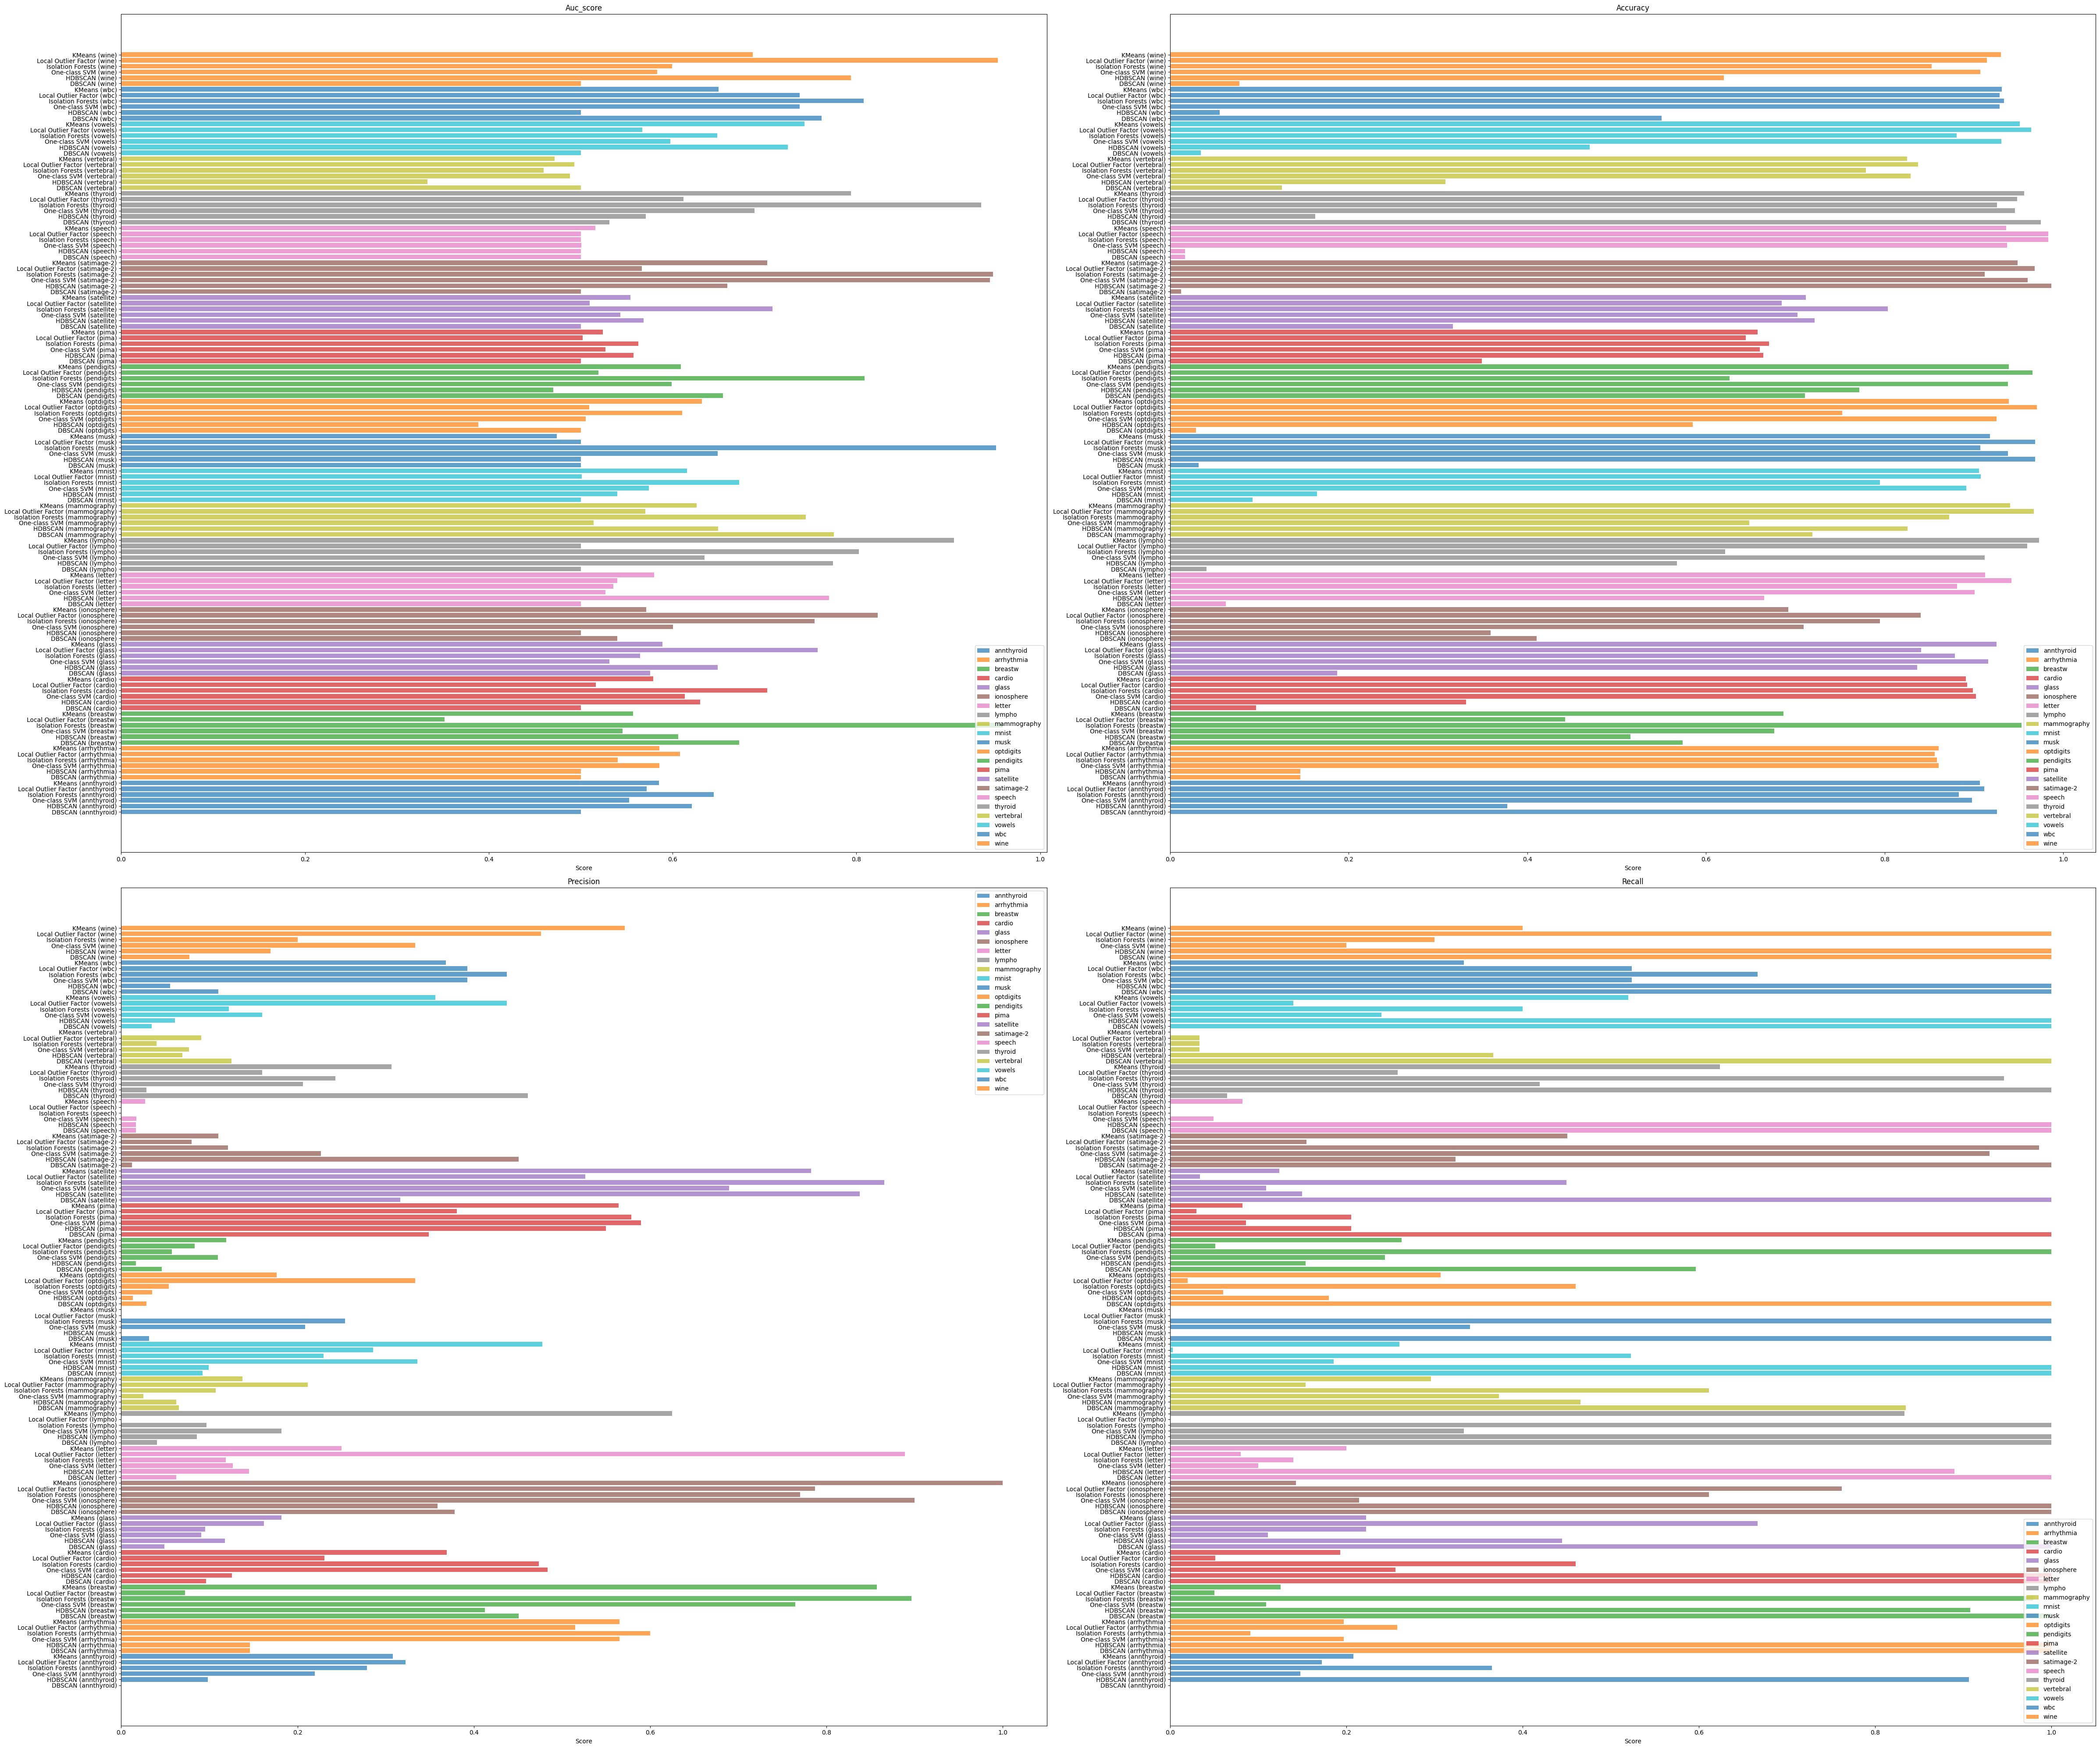

In [9]:
metrics = ["auc_score", "accuracy", "precision", "recall"]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(48, 40))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    for dataset, methods in results.items():
        scores = [methods[method][metric] for method in methods]
        axes[i].barh([f"{method} ({dataset})" for method in methods], scores, label=dataset, alpha=0.7)
    axes[i].set_title(metric.capitalize())
    axes[i].set_xlabel("Score")
    axes[i].legend()

plt.tight_layout()
plt.show()


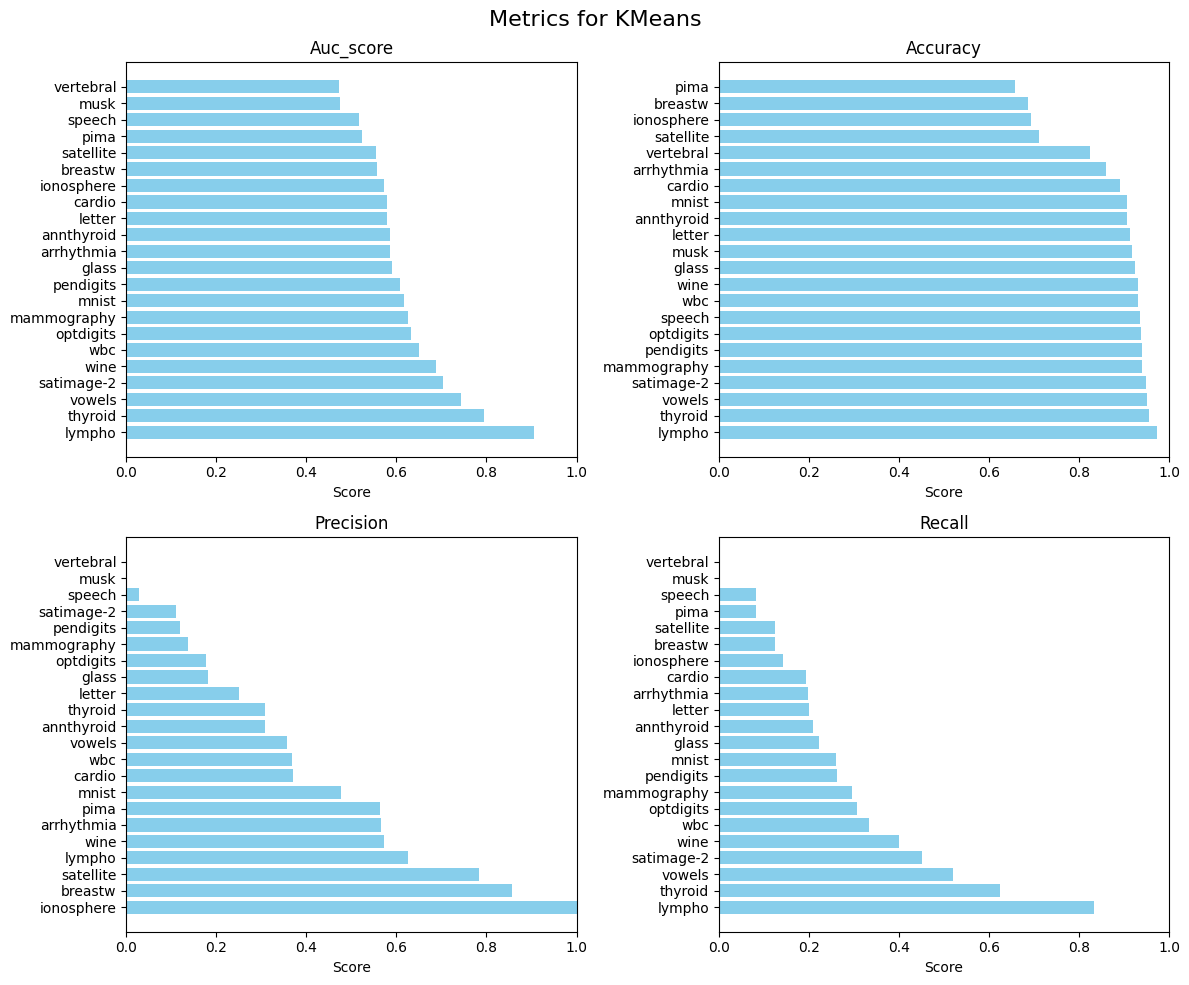

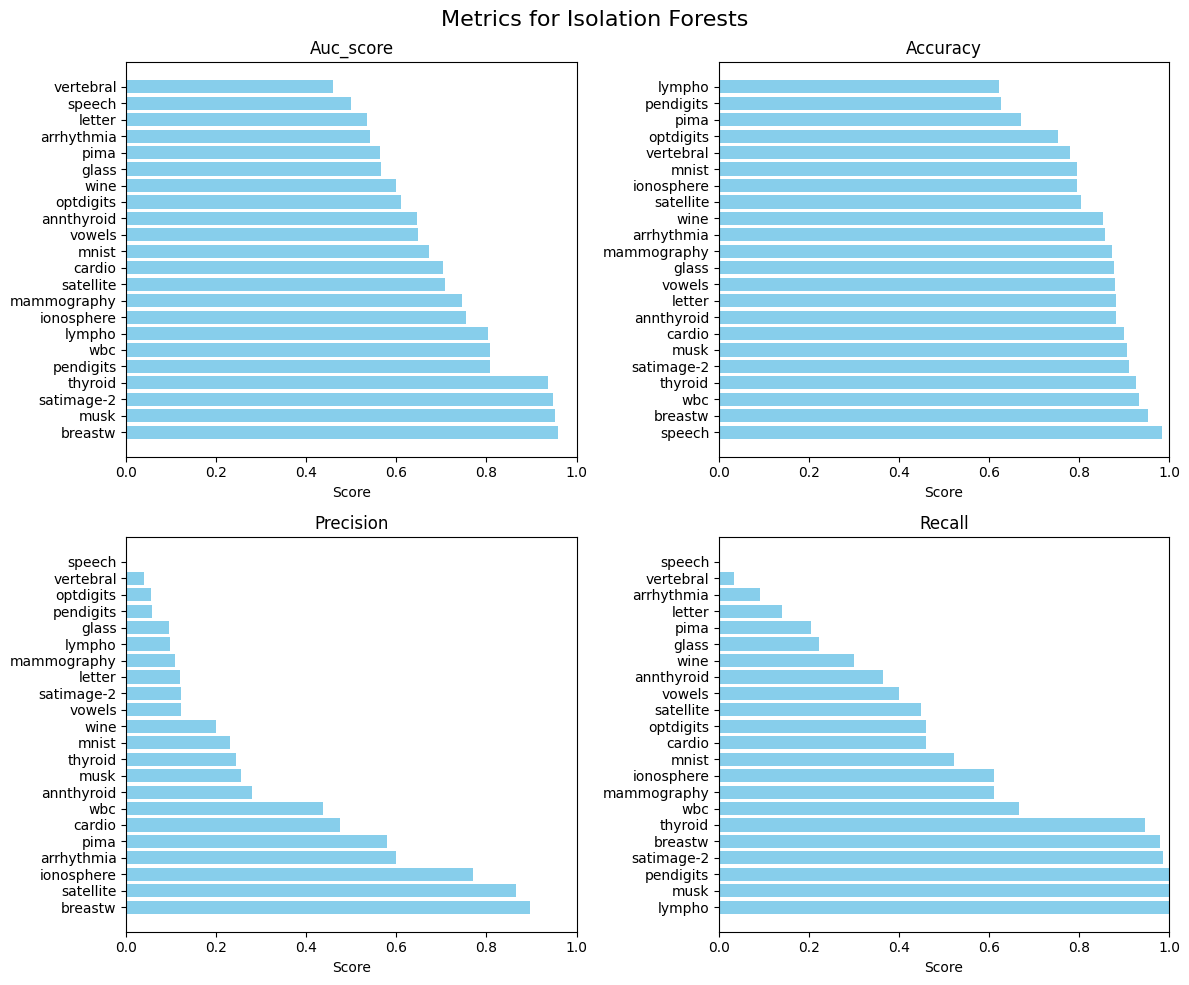

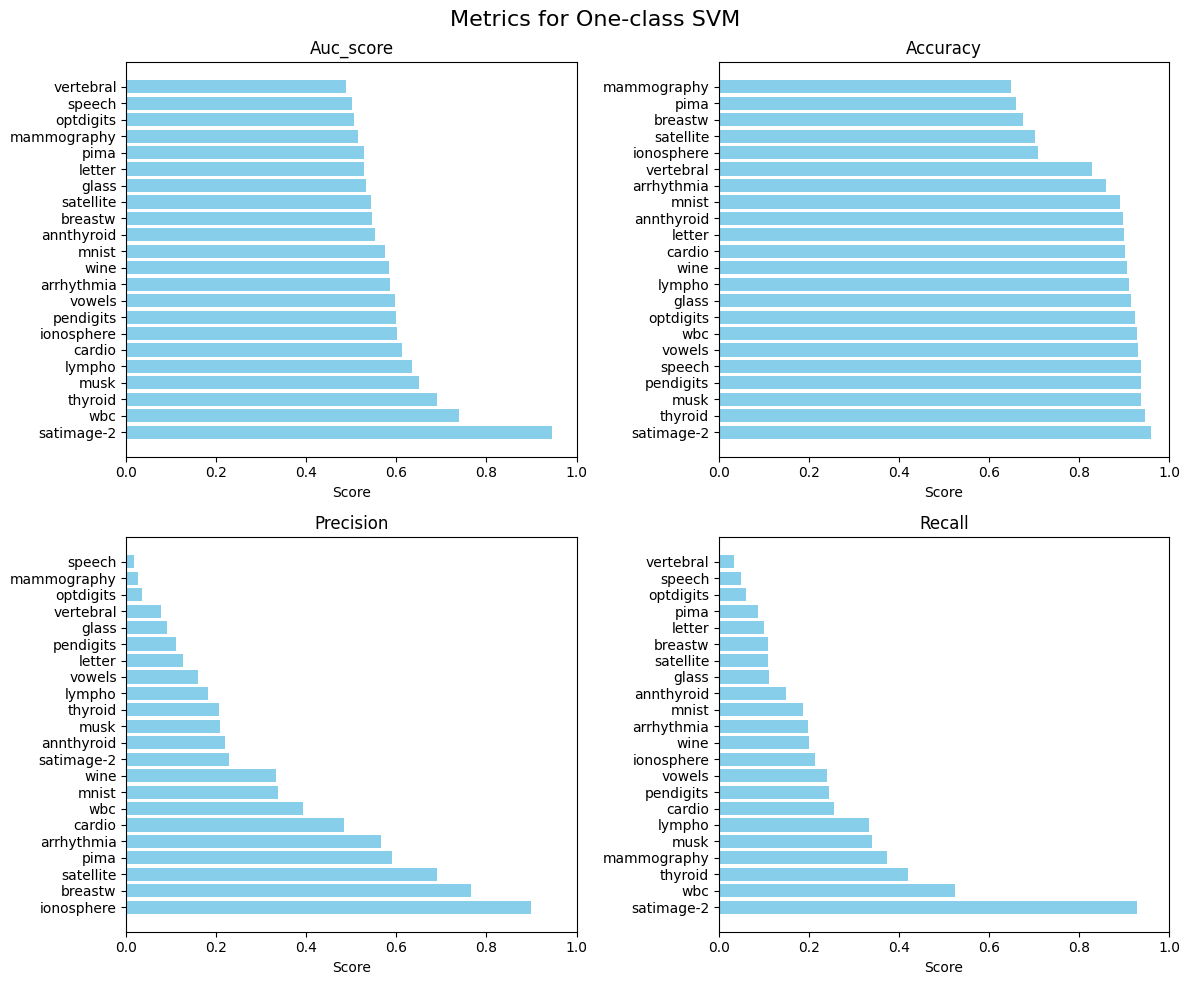

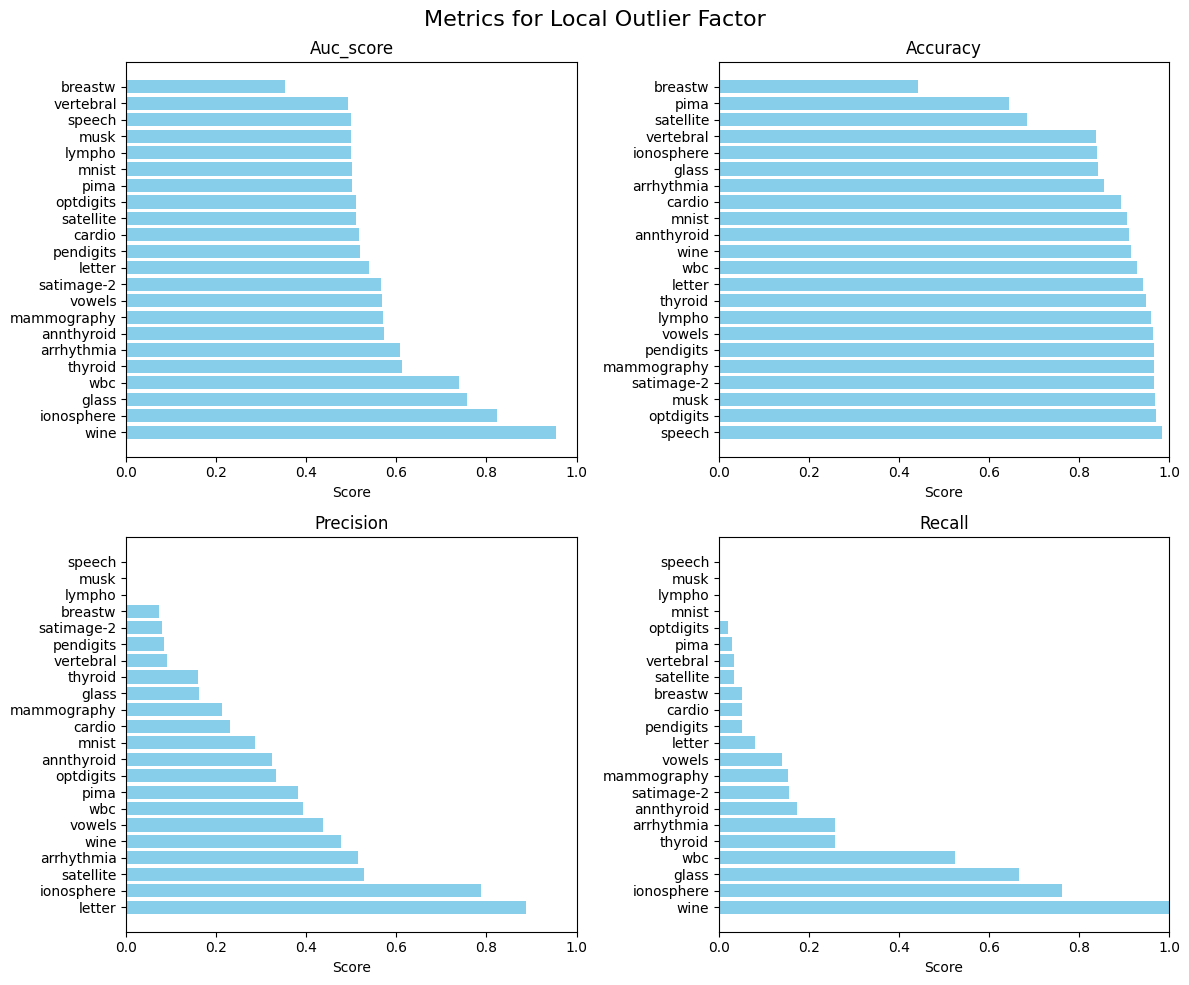

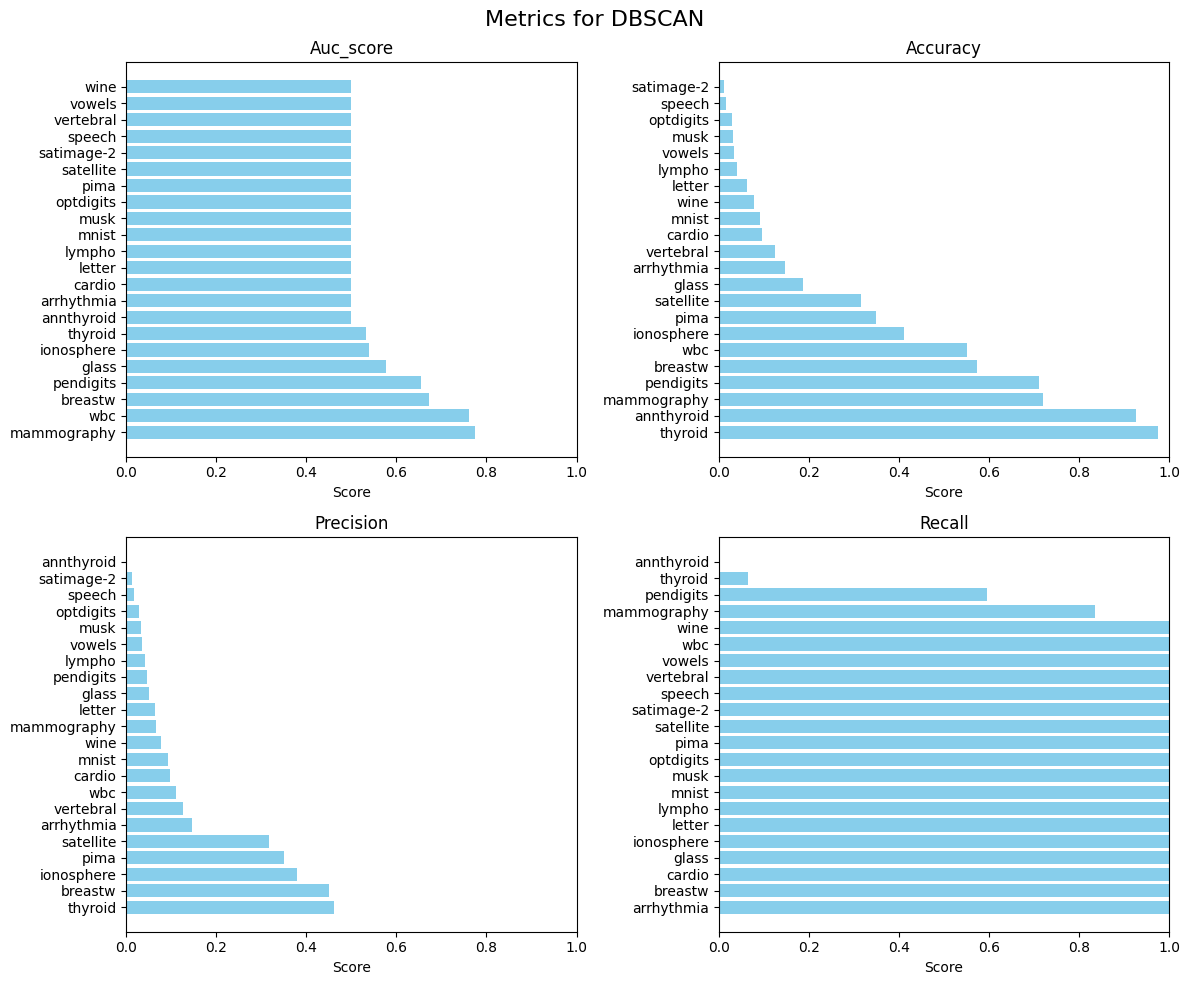

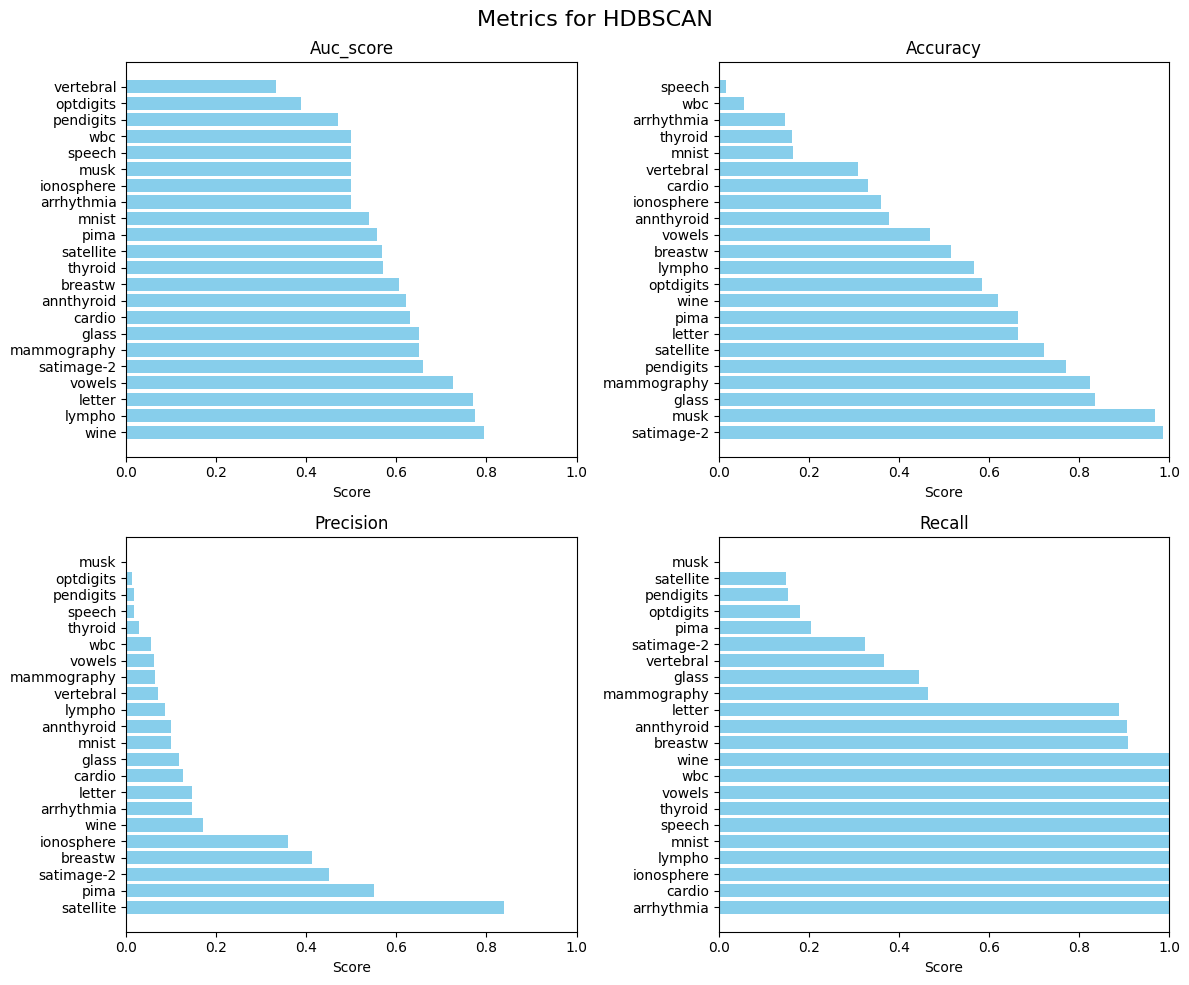

In [10]:
metrics = ["auc_score", "accuracy", "precision", "recall"]
methods = set(method for methods in results.values() for method in methods)

# One figure per method
for method in methods:
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), tight_layout=True)
    axes = axes.flatten()
    fig.suptitle(f"Metrics for {method}", fontsize=16)

    # Plot for metric
    for i, metric in enumerate(metrics):
        scores_and_datasets = []
        for dataset, methods_scores in results.items():
            if method in methods_scores:
                scores_and_datasets.append((methods_scores[method][metric], dataset))

        scores_and_datasets.sort(reverse=True, key=lambda x: x[0])

        scores = [sd[0] for sd in scores_and_datasets]
        datasets = [sd[1] for sd in scores_and_datasets]

        axes[i].barh(datasets, scores, color="skyblue")
        axes[i].set_title(str(metric.capitalize()))
        axes[i].set_xlabel("Score")
        axes[i].set_xlim(0, 1)

    plt.show()


# 5. Conclusions


### Isolation Forests
Typically score high in accuracy, precision, and recall, which makes them very effective on a variety of datasets.

They especially stand out in the breastw set with a very high auc_score.

### HDBSCAN
Shows significantly better recall than other methods, especially on data where other methods perform poorly.

However, often at the expense of precision, as can be seen in the thyroid collection.

### One-class SVM
Often has higher precision but lower recall, which suggests that it is more cautious in classifying observations as anomalies.

### DBSCAN and Local Outlier Factor
Often have very high recall but low precision, indicating a tendency to falsely classify normal observations as anomalies.

### DBSCAN
Often returns constant results for different sets (e.g. auc_score = 0.5, recall = 1.0), which may suggest that the algorithm creates one large group in which all points are treated as anomalies.

### KMeans
Is not intended for anomaly detection, but can be useful in this role when we correctly adjust the method of assessing the distance from cluster centroids.

Using a distance threshold to identify anomalies allows for a certain level of flexibility in modeling unusual behavior in the data.